In [5]:
# Importing libraries
import pandas as pd
from numpy import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.stats import norm
import os
import statsmodels.api as sm
import pylab
import time

# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2.0

# Set max row to 300
pd.set_option('display.max_rows', 300)
from IPython.display import Latex

## Part 1 - Stock Price Simulation

We have seen that it is assumed that stock price follows the Geometric Brownian Motion aslso denominated as GBM, written matheematically by :

$$ dS_{t} = rS_{t}dt + σS_{t}dW_{t} $$

where $dt$ is the time step, $S_{t}$ is the price of the underlying at time $t$, σ is constant volatility, $r$ is the constant risk-free interest rate and $W$ is the brownian motion or Wiener process. 

Applying Euler discretization of SDE, we get:

$$ S_{t+{\delta}t} = S_t * (1 + {r {\delta}t + {\sigma} {\sqrt{\delta}t} w_{t})} $$

The Forward Euler-Maruyama methods for GBM is given by:

$$ S_{t+dt} - S_t = rS_{t}dt + \sigma_{t}\phi\sqrt{dt}$$

where $\phi$ is a standard normal random number meaning, $\phi \sim N(0,1)$ 



In [2]:
def sim_path(s0, mu, sigma, horizon, timesteps, simulations, method="euler"):
    
    # Set the random seed to germ for reproducibility
    random.seed(10000) 

    # Read parameters
    S0 = s0          # initial spot price
    r = mu           # mu = rf in risk neutral framework 
    T = horizon      # time horizion
    ts = timesteps   # number of time steps
    n = simulations  # number of simulation
    dt = T/ts        # length of time interval  
    
    # Simulating 'n' asset price paths with 't' timesteps
    S = zeros((ts, n))
    S[0] = S0
    
    # Method parameters
    
    # Euler–Maruyama with Antithetic Variates is set by default if not specified
    
    if method=="euler":
        #Euler–Maruyama method
        for i in range(0, ts-1):
            w = random.standard_normal(n)                                               # Generate random numbers drawn from the standard normal distribution
            S[i+1] = S[i] * (1 + r * dt + sigma * np.sqrt(dt) * w)                         # vectorized operation for each timesteps
    elif method=="euler_ant":
        #Euler–Maruyama method with Antithetic Variates
        for i in range(0, ts-1):
            w = random.standard_normal(int(n/2))                                        # Generate psuedo standard normal random numbers
            w = concatenate((w,-w), axis=0)
            S[i+1] = S[i] * (1 + r * dt + sigma * np.sqrt(dt) * w)                      # vectorized operation for each timesteps   
    else:
        raise TypeError('Invalid option type')

    return S

In [3]:
# simulate for the given parameters
sim_price_euler = pd.DataFrame(sim_path(100, 0.05, 0.20, 1, 252, 100000, method= 'euler'))
sim_price_euler_ant = pd.DataFrame(sim_path(100, 0.05, 0.20, 1, 252, 100000, method= 'euler_ant'))


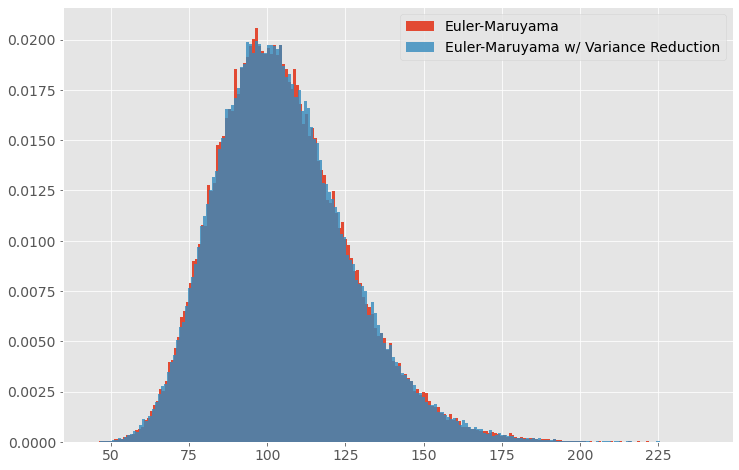

In [4]:
# plot of both histograms for comparison
plt.hist(sim_price_euler.iloc[-1], 200, stacked= True, density= True, alpha = 1, lw = 3, label= 'Euler-Maruyama')
plt.hist(sim_price_euler_ant.iloc[-1], 200, stacked= True, density= True, alpha = .8, lw = 3, label = 'Euler-Maruyama w/ Variance Reduction')
plt.legend()
plt.show()

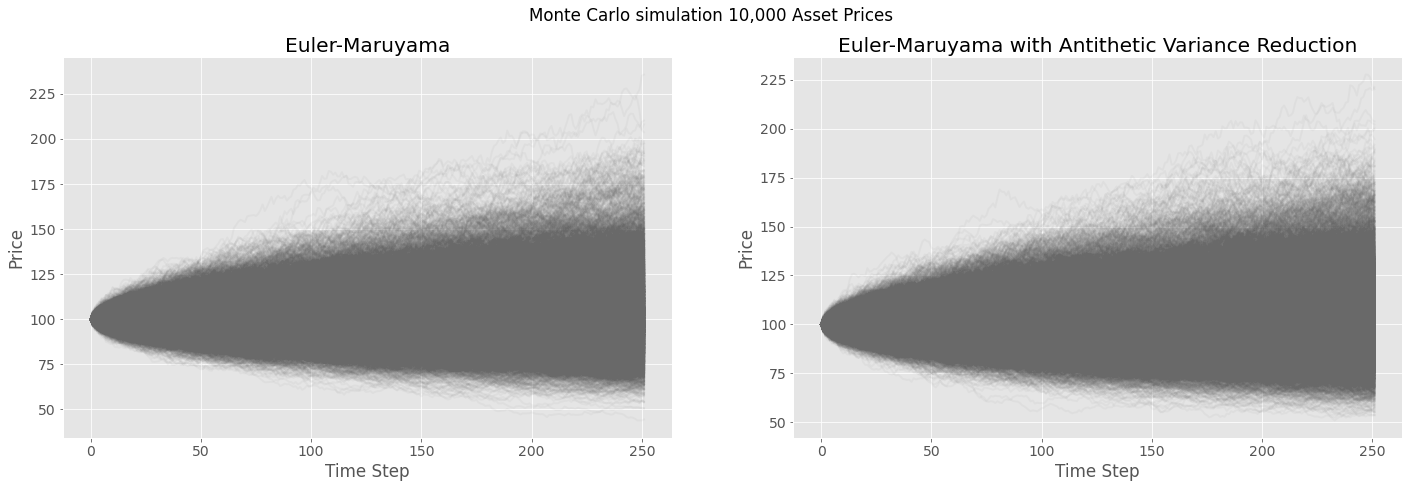

In [5]:
# Plot simulated stock price by methods
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (24,7))
fig.suptitle('Monte Carlo simulation 10,000 Asset Prices')

ax1.plot(sim_price_euler.iloc[:,:10000], color = 'dimgray', alpha = 0.05)
ax1.set_title("Euler-Maruyama")
ax1.set(xlabel = 'Time Step', ylabel = 'Price')
ax2.plot(sim_price_euler_ant.iloc[:,:10000], color = 'dimgray', alpha = 0.05)
ax2.set_title("Euler-Maruyama with Antithetic Variance Reduction")
ax2.set(xlabel = 'Time Step', ylabel = 'Price')

plt.show()


Before using the model on Asion and Looback options, I conducted some testing to ensure the statistical properties of the simulated stock price. These tests focuse on the normal random number generation (add martingale property if found). The top graph shows one randomly selected stock path over the predefined time horizon. The stock price is simulated using Euler-Marayuma. The bottom graph shows the empirical QQ plot of the random number used in the stock price simulation. We can se that the blue dots (data) are within a reasonable range around the black line, which indicates that they approximatly fololow the normal distribution.  

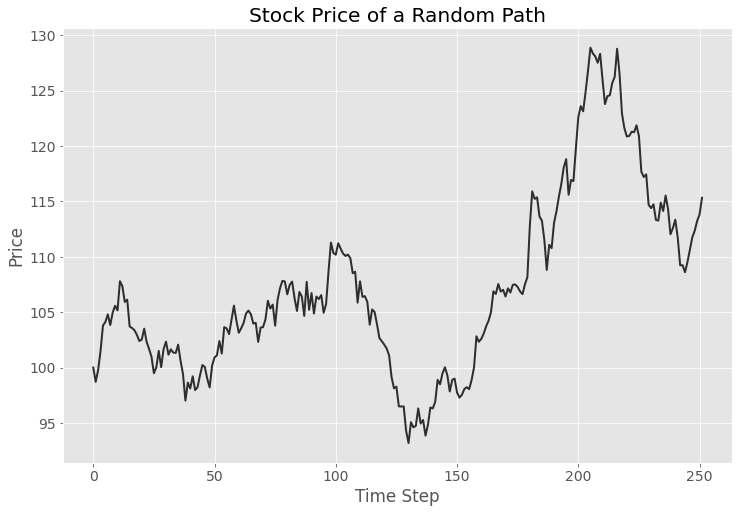

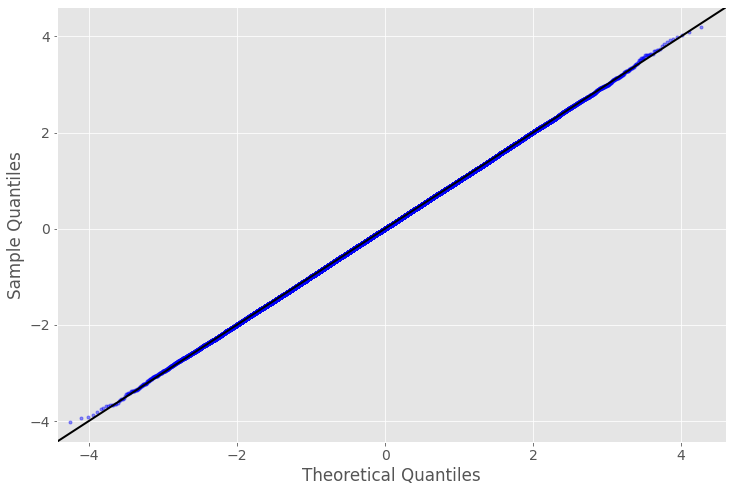

In [6]:
# Tests on the stock price simulation 
plt.plot(sim_price_euler.iloc[:,32768], color = 'black', alpha = 0.8)
plt.title("Stock Price of a Random Path")
plt.xlabel('Time Step')
plt.ylabel('Price')

pp = sm.ProbPlot(random.standard_normal(100000), fit= True)
qq = pp.qqplot(marker = '.', markerfacecolor='b', markeredgecolor = 'b', alpha = 0.4)
tu = sm.qqline(qq.axes[0], line = '45', fmt = 'k--')

plt.show()

## Part 2 - Asian Option Pricing 

The expected value of the discounted payoff under the resk-neutral density $\mathbb{Q}$
$$V(S,t) = e^{-r(T-t)}\mathbb{E}^\mathbb{Q}[\bm{Payoff}(S_t)]$$

The first thing to know is that the payoff of an asian option varies on option type, stike types (Fixed, Floating) and averaging method (Geometric vs Arithmetic sampling).

### 2.1 - Averaging Method

If we consider a fixed strike Asian option, the payoff of an Asian call and put option is: 
$$C(T) = max(A(0,T) - K, 0)$$
and 
$$P(T) = max(K-A(0,T),0)$$

where A(0,T) represent the averaged underlying stock price over the horizon period [0,T].

#### 2.1.1 - Arithmetic 

For the arithmetic averaging method we have to consider 2 different formula, the discrete time and the continuous time formula.

In discrete time, the formula is:
$$A(0,T) = \dfrac{1}{n}\displaystyle\sum_{i=1}^n St_i\;\;\; where,\; t_i = i.\dfrac{T}{n}$$

In continuous time, we have:
$$A(0,T) = \dfrac{1}{T}\displaystyle\int_{0}^T S(t)dt$$

#### 2.1.2 - Geometric

For the geometric averaging method we have to consider the 2 different formula as well.

In discrete time, we have:

$$A(0,T) = (\displaystyle\prod_{i = 0}^{n+1})^{\dfrac{1}{n+1}}\;\;\; where, \; t_i = i.\dfrac{T}{n} $$

In continuous time, we get:

$$A(0,T) = \exp(\dfrac{1}{T}\displaystyle\int_{0}^T \ln(S(t))dt)$$



##### Simulation

In [23]:
# Create a a new simultaion function unsing Euler–Maruyama with Antithetic Variates only
class Simulation:
    def __init__(self, s0, mu, sigma, horizon, time_steps, simulations):
        """
        :Parameters:
        S0: Stock price at time 0
        mu: Drift
        sigma: Volatility
        horizon: Expiry
        time_steps: Number of steps
        simulations: Number of simulation
        :return:
        Results in a panda DataFrame
        """
        # stock price at t = 0
        self.s0 = s0
        # time horizon before expiry 
        self.horizon = horizon
        # the number of simulation
        self.simulations = simulations
        # time steps
        self.time_steps = time_steps
        # volatility
        self.sigma = sigma
        # mu = rf in risk neutral framework
        self.mu = mu
        
    def get_result(self):
        # Set the random seed to germ for reproducibility
        random.seed(10000) 
        #Create empty list to store results 
        result = []
        dt = self.horizon*1.0/self.time_steps
        
        # Simulation
        for i in range(self.simulations):
            # list fot store each sim result
            simul = []
            s_before = self.s0
            simul.append(s_before)
            # for each time step
            for j in range(self.time_steps):
                s_after = s_before*(1 + self.mu*dt) + self.sigma*s_before*np.sqrt(dt)*np.random.normal(0,1)
                s_before = s_after
                simul.append(s_after)
            
            result.append(simul)
            
        return result

##### Asian Option Pricing 

In [47]:
# Creating various fonctions to price the asian option using the method illustrated above
class Sim_asian:
    def __init__(self, sim_result, mu, horizon, Opt_type, sampling_window = None, K = None):
        # sim_result type: dataframe
        # col: numbers of simulation
        # index: time_step
        self.sim_result = sim_result
        # option type 'call' or 'put'
        self.Opt_type = Opt_type
        # risk-free rate
        self.mu = mu
        # horizon
        self.horizon = horizon
        # None value for default since floating circumstance
        self.K = K
        # sampling_window for discrete sampling
        self.sampling_window = sampling_window
        
    def disc_fix_a(self):
        # calculate option value with discrete sampling
        # fixed strike and arithmetic average
        time_steps = len(self.sim_result)
        sample_index = [i for i in range(time_steps) if i%self.sampling_window == 0]
        sample_data = self.sim_result.iloc[sample_index]
        A = sample_data.mean()
        if self.Opt_type == 'call':
            payoff = A.apply(lambda x: max(x - self.K, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = A.apply(lambda x: max(self.K - x, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        
    def disc_fix_g(self):
        # calculate option value with discrete sampling
        # fixed strike and Geometric average
        time_steps = len(self.sim_result)
        sample_index = [i for i in range(time_steps) if i%self.sampling_window == 0]
        sample_data = self.sim_result.iloc[sample_index]
        A = sample_data.apply(np.log).mean().apply(np.exp)
        if self.Opt_type == 'call':
            payoff = A.apply(lambda x: max(x - self.K, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = A.apply(lambda x: max(self.K - x, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        
    def disc_float_a(self):
        # calculate option value with discrete sampling
        # floating strike and arithmetic average
        time_steps = len(self.sim_result)
        sample_index = [i for i in range(time_steps) if i%self.sampling_window == 0]
        sample_data = self.sim_result.iloc[sample_index]
        A = sample_data.mean()
        if self.Opt_type == 'call':
            payoff = (A - sample_data.iloc[-1,:]).apply(lambda x: max(x, 0))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = (sample_data.iloc[-1,:] - A).apply(lambda x: max(x, 0))
            return payoff.mean()
        
    def disc_float_g(self):
        # calculate option value with discrete sampling
        # floating strike and Geometric average
        time_steps = len(self.sim_result)
        sample_index = [i for i in range(time_steps) if i%self.sampling_window == 0]
        sample_data = self.sim_result.iloc[sample_index]
        A = sample_data.apply(np.log).mean().apply(np.exp)
        if self.Opt_type == 'call':
            payoff = (A - sample_data.iloc[-1,:]).apply(lambda x: max(x, 0))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = (sample_data.iloc[-1,:] - A).apply(lambda x: max(x, 0))
            return payoff.mean()
        
    def cont_fix_a(self):
        # calculate option value with continuous sampling
        # fixed strike and arithmetic average
        A = self.sim_result.mean()
        if self.Opt_type == 'call':
            payoff = A.apply(lambda x: max(x - self.K, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = A.apply(lambda x: max(self.K - x, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        
    def cont_fix_g(self):
        # calculate option value with continuous sampling
        # fixed strike and Geometric average
        A = self.sim_result.apply(np.log).mean().apply(np.exp)
        if self.Opt_type == 'call':
            payoff = A.apply(lambda x: max(x - self.K, 0)* np.exp(-self.mu*self.horizon))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = A.apply(lambda x: max(self.K - x, 0)*np.exp(-self.mu*self.horizon))
            return payoff.mean()
        
    def cont_float_a(self):
        # calculate option value with continuous sampling
        # floating strike and arithmetic average
        A = self.sim_result.mean()
        if self.Opt_type == 'call':
            payoff = (A - self.sim_result.iloc[-1,:]).apply(lambda x: max(x, 0))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = (self.sim_result.iloc[-1,:] - A).apply(lambda x: max(x, 0))
            return payoff.mean()

    def cont_float_g(self):
        # calculate option value with continuous sampling
        # fixed strike and Geometric average
        A = self.sim_result.apply(np.log).mean().apply(np.exp)
        if self.Opt_type == 'call':
            payoff = (A - self.sim_result.iloc[-1,:]).apply(lambda x: max(x, 0))
            return payoff.mean()
        elif self.Opt_type == 'put':
            payoff = (self.sim_result.iloc[-1,:] - A).apply(lambda x: max(x, 0))
            return payoff.mean()

In [24]:
# set parameters
# inital price
s0 = 100
# expiry
horizon = 1
# number of simulation
simulations = 50
# time step
time_steps = 252
# volatility
sigma = 0.2
# risk free rate
mu = 0.05

In [33]:
simulations = 1
# simulation
sim = Simulation(s0 = s0, mu = mu, sigma= sigma, horizon= horizon, time_steps= time_steps, simulations= simulations)
result = sim.get_result()
result = pd.DataFrame(result).T
result.columns = ['simulation']

arithmetric = []
geometric = []

for i in range(len(result)):
    arithmetric.append(result.iloc[:i, :].mean())
    geometric.append(result.iloc[:i,:].apply(np.log).mean().apply(np.exp))
result['arithmetric'] = arithmetric
result['geometric'] = geometric



In [34]:
sampling_window = 20

#Create empty lsit for discrete arithmetric and geometric 
disc_arithmetric = []
disc_geometric = []

# get index so we know which data should be updated into average
sample_index = [i for i in range(time_steps) if i%sampling_window == 0]

arith = result.iloc[0]['simulation']
geo = result.iloc[0]['simulation']
count = 0
for i in range(len(result)):
    if i%sampling_window == 0 and i != 0:
        count += 1
        arith = (1.0*result.iloc[i]['simulation']/count) + ((count-1)* arith*1.0/count)
        geo = np.exp(1.0*np.log(result.iloc[i]['simulation'])/count + (count - 1)*np.log(geo)*1.0/count)
    disc_arithmetric.append(arith)
    disc_geometric.append(geo)
result['d_arithmetric'] = disc_arithmetric
result['d_geometric'] = disc_geometric


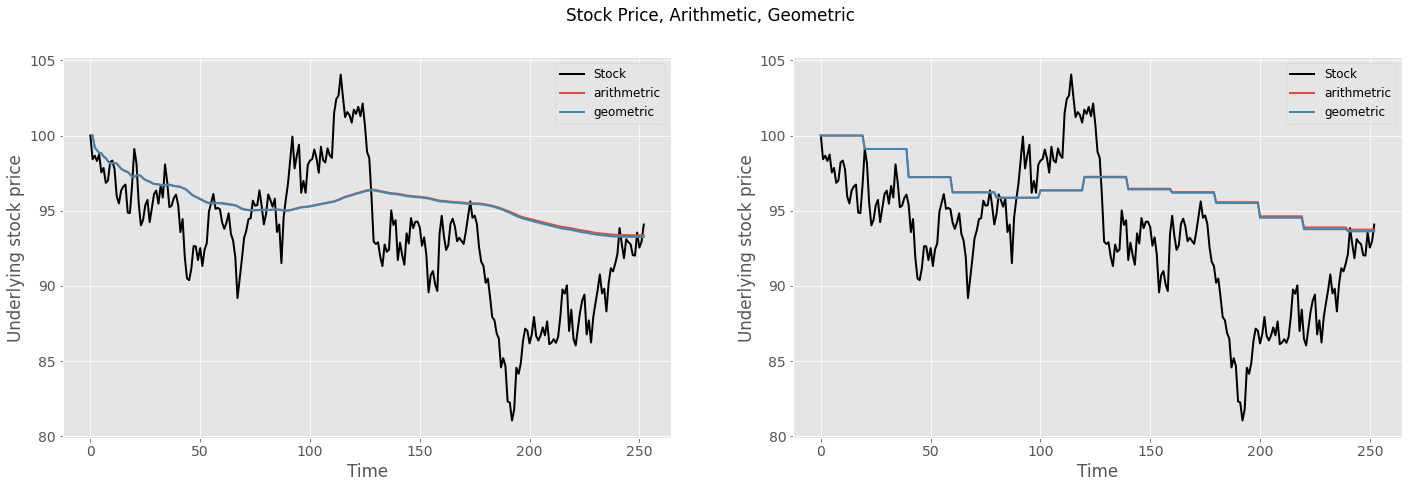

In [43]:
# Plot simulated stock price by methods
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (24,7))
fig.suptitle('Stock Price, Arithmetic, Geometric')

ax1.plot(result.index, result['simulation'], label = 'Stock', color = 'black')
ax1.plot(result.index, result['arithmetric'], label = 'arithmetric')
ax1.plot(result.index, result['geometric'], label = 'geometric')
ax1.set(xlabel = 'Time', ylabel = 'Underlying stock price')
ax1.legend(fontsize = 12)

ax2.plot(result.index, result['simulation'], label = 'Stock', color = 'black')
ax2.plot(result.index, result['d_arithmetric'], label = 'arithmetric')
ax2.plot(result.index, result['d_geometric'], label = 'geometric')
ax2.set(xlabel = 'Time', ylabel = 'Underlying stock price')
ax2.legend(fontsize = 12)

plt.show()

#### Option pricing Results

In [51]:
# 2,000 Simulation

if __name__ == '__main__':
    
    # simulation uderlying stock price
    sim = Simulation(s0 = 100, mu =0.05, sigma = 0.2, horizon = 1, time_steps=252 , simulations= 2000)
    result = sim.get_result()
    # change type to dataframe
    result = pd.DataFrame(result).T
    asian_call = Sim_asian(sim_result = result, mu = 0.05, horizon = 1, Opt_type = 'call', sampling_window = 20, K = 100)
    print ('# ---------------------- Asian Call ---------------------- #')
    
    print ('Asian Call option price fixed discrete arithmetic: ', asian_call.disc_fix_a())
    print ('Asian Call option price fixed discrete geometric: ', asian_call.disc_fix_g())
    print ('Asian Call option price floating discrete arithmetic: ', asian_call.disc_float_a())
    print ('Asian Call option price floating discrete geometric: ', asian_call.disc_float_g())
    print ('Asian Call option price fixed continuous arithmetic: ', asian_call.cont_fix_a())
    print ('Asian Call option price fixed continuous geometric: ', asian_call.cont_fix_g())
    print ('Asian Call option price floating continuous arithmetic: ', asian_call.cont_float_a())
    print ('Asian Call option price floating continuous geometric: ', asian_call.cont_float_g())
    
    asian_put = Sim_asian(sim_result = result, mu = 0.05, horizon = 1, Opt_type = 'put', sampling_window = 20, K = 100)
    print ("")
    print ('# ---------------------- Asian Put ---------------------- #')
    
    print ('Asian Put option price fixed discrete arithmetic: ', asian_put.disc_fix_a())
    print ('Asian Put option price fixed discrete geometric: ', asian_put.disc_fix_g())
    print ('Asian Put option price floating discrete arithmetic: ', asian_put.disc_float_a())
    print ('Asian Put option price floating discrete geometric: ', asian_put.disc_float_g())
    print ('Asian Put option price fixed continuous arithmetic: ', asian_put.cont_fix_a())
    print ('Asian Put option price fixed continuous geometric: ', asian_put.cont_fix_g())
    print ('Asian Put option price floating continuous arithmetic: ', asian_put.cont_float_a())
    print ('Asian Put option price floating continuous geometric: ', asian_put.cont_float_g())

# ---------------------- Asian Call ---------------------- #
Asian Call option price fixed discrete arithmetic:  5.098543995439721
Asian Call option price fixed discrete geometric:  4.896839093103207
Asian Call option price floating discrete arithmetic:  3.5582689076384404
Asian Call option price floating discrete geometric:  3.4171375853954795
Asian Call option price fixed continuous arithmetic:  5.317786903894492
Asian Call option price fixed continuous geometric:  5.120926915442222
Asian Call option price floating continuous arithmetic:  3.7408505733598085
Asian Call option price floating continuous geometric:  3.6027311497531675

# ---------------------- Asian Put ---------------------- #
Asian Put option price fixed discrete arithmetic:  3.423894754425291
Asian Put option price fixed discrete geometric:  3.549984091590567
Asian Put option price floating discrete arithmetic:  5.398781510583513
Asian Put option price floating discrete geometric:  5.602250797887351
Asian Put option p

In [52]:
# 20,000 Simulation

if __name__ == '__main__':
    
    # simulation uderlying stock price
    sim = Simulation(s0 = 100, mu =0.05, sigma = 0.2, horizon = 1, time_steps=252 , simulations= 20000)
    result = sim.get_result()
    # change type to dataframe
    result = pd.DataFrame(result).T
    asian_call = Sim_asian(sim_result = result, mu = 0.05, horizon = 1, Opt_type = 'call', sampling_window = 20, K = 100)
    print ('# ---------------------- Asian Call ---------------------- #')
    
    print ('Asian Call option price fixed discrete arithmetic: ', asian_call.disc_fix_a())
    print ('Asian Call option price fixed discrete geometric: ', asian_call.disc_fix_g())
    print ('Asian Call option price floating discrete arithmetic: ', asian_call.disc_float_a())
    print ('Asian Call option price floating discrete geometric: ', asian_call.disc_float_g())
    print ('Asian Call option price fixed continuous arithmetic: ', asian_call.cont_fix_a())
    print ('Asian Call option price fixed continuous geometric: ', asian_call.cont_fix_g())
    print ('Asian Call option price floating continuous arithmetic: ', asian_call.cont_float_a())
    print ('Asian Call option price floating continuous geometric: ', asian_call.cont_float_g())
    
    asian_put = Sim_asian(sim_result = result, mu = 0.05, horizon = 1, Opt_type = 'put', sampling_window = 20, K = 100)
    print ("")
    print ('# ---------------------- Asian Put ---------------------- #')
    
    print ('Asian Put option price fixed discrete arithmetic: ', asian_put.disc_fix_a())
    print ('Asian Put option price fixed discrete geometric: ', asian_put.disc_fix_g())
    print ('Asian Put option price floating discrete arithmetic: ', asian_put.disc_float_a())
    print ('Asian Put option price floating discrete geometric: ', asian_put.disc_float_g())
    print ('Asian Put option price fixed continuous arithmetic: ', asian_put.cont_fix_a())
    print ('Asian Put option price fixed continuous geometric: ', asian_put.cont_fix_g())
    print ('Asian Put option price floating continuous arithmetic: ', asian_put.cont_float_a())
    print ('Asian Put option price floating continuous geometric: ', asian_put.cont_float_g())

# ---------------------- Asian Call ---------------------- #
Asian Call option price fixed discrete arithmetic:  5.488731569284781
Asian Call option price fixed discrete geometric:  5.268018645236988
Asian Call option price floating discrete arithmetic:  3.3952708852619113
Asian Call option price floating discrete geometric:  3.2599192858756436
Asian Call option price fixed continuous arithmetic:  5.7358623967063975
Asian Call option price fixed continuous geometric:  5.520741498927887
Asian Call option price floating continuous arithmetic:  3.530499024779272
Asian Call option price floating continuous geometric:  3.3967032530521597

# ---------------------- Asian Put ---------------------- #
Asian Put option price fixed discrete arithmetic:  3.216402077977221
Asian Put option price fixed discrete geometric:  3.337810575067535
Asian Put option price floating discrete arithmetic:  5.82685245258244
Asian Put option price floating discrete geometric:  6.051163214689707
Asian Put option pr

In [53]:
# 200,000 Simulation

if __name__ == '__main__':
    
    # simulation uderlying stock price
    sim = Simulation(s0 = 100, mu =0.05, sigma = 0.2, horizon = 1, time_steps=252 , simulations= 200000)
    result = sim.get_result()
    # change type to dataframe
    result = pd.DataFrame(result).T
    asian_call = Sim_asian(sim_result = result, mu = 0.05, horizon = 1, Opt_type = 'call', sampling_window = 20, K = 100)
    print ('# ---------------------- Asian Call ---------------------- #')
    
    print ('Asian Call option price fixed discrete arithmetic: ', asian_call.disc_fix_a())
    print ('Asian Call option price fixed discrete geometric: ', asian_call.disc_fix_g())
    print ('Asian Call option price floating discrete arithmetic: ', asian_call.disc_float_a())
    print ('Asian Call option price floating discrete geometric: ', asian_call.disc_float_g())
    print ('Asian Call option price fixed continuous arithmetic: ', asian_call.cont_fix_a())
    print ('Asian Call option price fixed continuous geometric: ', asian_call.cont_fix_g())
    print ('Asian Call option price floating continuous arithmetic: ', asian_call.cont_float_a())
    print ('Asian Call option price floating continuous geometric: ', asian_call.cont_float_g())
    
    asian_put = Sim_asian(sim_result = result, mu = 0.05, horizon = 1, Opt_type = 'put', sampling_window = 20, K = 100)
    print ("")
    print ('# ---------------------- Asian Put ---------------------- #')
    
    print ('Asian Put option price fixed discrete arithmetic: ', asian_put.disc_fix_a())
    print ('Asian Put option price fixed discrete geometric: ', asian_put.disc_fix_g())
    print ('Asian Put option price floating discrete arithmetic: ', asian_put.disc_float_a())
    print ('Asian Put option price floating discrete geometric: ', asian_put.disc_float_g())
    print ('Asian Put option price fixed continuous arithmetic: ', asian_put.cont_fix_a())
    print ('Asian Put option price fixed continuous geometric: ', asian_put.cont_fix_g())
    print ('Asian Put option price floating continuous arithmetic: ', asian_put.cont_float_a())
    print ('Asian Put option price floating continuous geometric: ', asian_put.cont_float_g())

# ---------------------- Asian Call ---------------------- #
Asian Call option price fixed discrete arithmetic:  5.50574004063268
Asian Call option price fixed discrete geometric:  5.283853764898165
Asian Call option price floating discrete arithmetic:  3.4121865669518807
Asian Call option price floating discrete geometric:  3.2780173960152936
Asian Call option price fixed continuous arithmetic:  5.7569724393111885
Asian Call option price fixed continuous geometric:  5.540119023490807
Asian Call option price floating continuous arithmetic:  3.563819343800852
Asian Call option price floating continuous geometric:  3.4310499690850738

# ---------------------- Asian Put ---------------------- #
Asian Put option price fixed discrete arithmetic:  3.204337290168455
Asian Put option price fixed discrete geometric:  3.3255321826953024
Asian Put option price floating discrete arithmetic:  5.86266853777941
Asian Put option price floating discrete geometric:  6.089170682746744
Asian Put option pr

Based on the analysis we can clearly see that when we increase the number of simulation we increase the accuracy of the Option price 

## Lookback Option - Fixed strike

### Path-Dependent Options - Lookback Options

The option payoffs are dependent on the extreme values, maximum or minimum, of the underlying asset prices over a certain time period (lookback period). There are two standard lookback options: fixed strike and floating strike. In this analysis I will focuse on fixed strike lookback option options that pay the difference if positive between the max ($M_0^T$) or min ($m_0^T$) of a set of observations, over a lookback period $[0,T]$ of the asset price $S_{t_i}$ and the strike price $K$ at the maturity date $T$.

For an Fixed Strike Lookback Call Options: $C_T = max(0, M_0^T - K)$

For an Fixed Strike Lookback Put Options: $C_T = max(0, K - m_0^T)$

Where:
 $M_0^T = max(S_{t_i} : i = 1,...,N)$
 $m_0^T = min(S_{t_i} : i = 1,...,N)$

### Heston Model for Stochastic Volatility

<i>Underlying SDE's under risk-neutral measure:

$$dS_{t} = (r-\delta) S_{t} dt + \sqrt{v_{t}} S_{t} dW^\mathbb{Q}_{1,t}$$

<i>Variance Process:

$$dv_{t} = \kappa (\theta - v_{t})dt + \sigma \sqrt{v_{t}} dW^\mathbb{Q}_{2,t}$$

    
$\rho^\mathbb{Q} dt=dW^\mathbb{Q}_{1,t} dW^\mathbb{Q}_{2,t}$
    
I assume no correlation or $\rho = 0$

I will use different kinds of models to price the lookback option and compare them at the end in a table to illustrate the findings drawn from the analysis.

In [3]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 100        # strike price
T = 1.0        # time to maturity in years
r = 0.05       # annual risk-free rate
vol = 0.20     # volatility (%)
div = 0     # continuous dividend yield

# steps & Simulation
N = 252      # number of time intervals
M = 10000    # number of simulations

# Assume evenly spaced discrete lookback
dt = T/N

# Assuming some Heston parameters 
kappa = 5.0      # rate of mean reversion of the variance process 
vt0 = vol**2   # variance
theta = 0.2**2   # Long term mean variance 
sigma = 0.02     # Volatility of volatility

#### Slow computation 

In [17]:

# Precompute constants
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
# Generate Wiener variables

for i in range(M):
    
    St = S0
    vt = vt0
    St_max = S0
    
    for j in range(N):
        W = np.random.normal(0, 1, size=(2))
        # variance process
        vt = vt + kappadt*(theta-vt) + sigmasdt*np.sqrt(vt)*W[0]
        
        # asset process        
        St = St*np.exp( (r-div-0.5*vt)*dt + np.sqrt(vt*dt)*W[1])
        
        if St > St_max:
            St_max = St
    
    CT = max(0, St_max - K)
    # print(CT)    
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0_slow = np.exp(-r*T)*sum_CT/M
SE_slow = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) ) / np.sqrt(M)


print("Call value is ${0} with SE +/- {1}".format(np.round(C0_slow,3),np.round(SE_slow,3)))

Call value is $18.113 with SE +/- 0.152


#### Fast computaion

In [18]:

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Generate Wiener variables

W = np.random.normal(0, 1, size=(N,M,2))

# arrays for storing prices and variances
St = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    
    mask = np.where(St[j] > St_max)
    St_max[mask] = St[j][mask]

# Compute Expectation and SE
CT = np.maximum(0, St_max - K)
C0_fast = np.exp(-r*T)*np.sum(CT)/M

SE_fast = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) ) /np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,2),np.round(SE_fast,2)))

Call value is $18.05 with SE +/- 0.15


#### Antithetic Variance reduction

In [26]:

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Generate Wiener variables

W = np.random.normal(0, 1, size=(N,M,2))

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    St2[j] = St2[j-1]*np.exp( nudt - np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    
    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]

# Compute Expectation and SE
CT = 0.5 * ( np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) )
C0_av = np.exp(-r*T)*np.sum(CT)/M

SE_av = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) ) /np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av,2),np.round(SE_av,2)))

Call value is $18.41 with SE +/- 0.06


#### Analytical Solution for Continuous Observations 

There is no analytical solution for the price of European fixed strike lookback call options with discrete fixings and stochastic volatility under Heston model. However there is a simple analytical formula for the price of a continuously monitored (fixing) fixed strike lookback call with constant volatility. I will use this simple analytical formula to gauge inthe monte carlo simulation the delta, gamma and vega to then use linear regression to determine what percentage minimizes the squared error of the discrete lookback call with stochastic volatility to the analytical solution.

$C_{FIXED \ STRIKE \ LOOKBACK \ CALL} = G + Se^{-\delta T}N(x+\sigma\sqrt{T})- Ke^{-rT} (x) - \frac{S}{B}(e^{-rT}(\frac{E}{S})^B N(x+(1-B)\sigma \sqrt{T}) - e^{-\delta T}N(x+\sigma\sqrt{T}))$

Where:

$$B = \frac{2(r-\delta)}{\sigma^2}$$

$$x = \frac{ln(\frac{S}{E}) + ((r-\delta)-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}$$

$\begin{array}{ c l }
    E=K, \; G=0 & \quad \textrm{if } K \geq M \\
    E=M, \; G=e^{-rt}(M-K)                 & \quad \textrm{otherwise}
\end{array}$


In [1]:
class fixed_strike_lookback_call:
    def __init__(self, r, S, K, T, M, vol, div=0):
        self.r = r
        self.S = S
        self.K = K
        self.T = T
        self.M = M
        self.vol = vol
        self.div = div
    
    def option_price_vectorized(self):
        "Calculate fixed strike lookback call price of call/put"
        E = np.where(self.K < self.M, self.M, self.K)
        G = np.where(self.K < self.M, np.exp(-self.r*self.T)*(self.M-self.K), 0)
        
        x = (np.log(self.S/E) + ((self.r-self.div) - self.vol**2/2)*self.T)/(self.vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(self.vol**2)

        price = G + self.S*np.exp(-self.div*T)*norm.cdf(x+self.vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - self.S/B*(np.exp(-self.r*self.T)*(E/self.S)**B * norm.cdf(x+(1-B)*self.vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+self.vol*np.sqrt(self.T), 0, 1))

        return price
    
    def option_price_fd(self, S, vol):
        "Calculate fixed strike lookback call price of call/put"
        if self.K < self.M:
            E = self.M
            G = np.exp(-self.r*self.T)*(self.M-self.K)
        else:
            E = self.K
            G = 0
        x = (np.log(S/E) + ((self.r-self.div) - vol**2/2)*self.T)/(vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(vol**2)

        price = G + S*np.exp(-self.div*T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1)
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - S/B*(np.exp(-self.r*self.T)*(E/S)**B * norm.cdf(x+(1-B)*vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1))

        return price
    
    def option_price_fd_vectorized(self, S, vol):
        "Calculate fixed strike lookback call price of call/put"
        E = np.where(self.K < self.M, self.M, self.K)
        G = np.where(self.K < self.M, np.exp(-self.r*self.T)*(self.M-self.K), 0)
 
        x = (np.log(S/E) + ((self.r-self.div) - vol**2/2)*self.T)/(vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(vol**2)

        price = G + S*np.exp(-self.div*T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - S/B*(np.exp(-self.r*self.T)*(E/S)**B * norm.cdf(x+(1-B)*vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1))

        return price

    def FD_S(self, S):
        vol = self.vol
        return self.option_price_fd_vectorized(S, vol)

    def FD_vol(self, vol):
        S = self.S
        return self.option_price_fd_vectorized(S, vol)

    def delta_fd(self, delta=0.001):
        deltaS = delta*self.S
        return (self.FD_S(self.S+deltaS)-self.FD_S(self.S-deltaS)) / (2*deltaS)

    def gamma_fd(self, delta=0.001):
        deltaS = delta*self.S
        return (self.FD_S(self.S+deltaS)-2*self.FD_S(self.S)+self.FD_S(self.S-deltaS)) / (deltaS**2)

    def vega_fd(self, delta=0.001):
        deltaV = delta*self.vol
        return (self.FD_vol(self.vol+deltaV)-self.FD_vol(self.vol-deltaV))/(2*deltaV)

In [6]:
cont_call = fixed_strike_lookback_call(r, S0, K, T, S0, vol, div)

print("Option Price: ", round(cont_call.option_price_vectorized(),4))
print("Delta: ", round(cont_call.delta_fd(),4))
print("Gamma: ", round(cont_call.gamma_fd(),4))
print("Vega: ", round(cont_call.vega_fd(),4))

ContPrice = cont_call.option_price_vectorized()

Option Price:  19.1676
Delta:  1.1429
Gamma:  0.0312
Vega:  87.1704


##### General Control Variate Equation

For J control variates we have:

$ \Large C_0\exp(rT) = C_T - \sum^J_{i=j}\beta_j cv_j + \eta$

where
- $\beta_j$ are factors to account for the "true" linear relationship between the option pay-off and the control variate $cv_j$
- $\eta$ accounts for errors:
    - discrete rebalancing
    - approximations in hedge sensitivities (calc. delta / gamma)
    
    
Option price as the sum of the linear relationships with J control variates
    
$ \large C_T =\beta_0 + \sum^J_{i=j}\beta_j cv_j + \eta$

where $\beta_0 = C_0\exp(rT)$ is the forward price of the option

If we perform M simulations at discrete time intervals N we can regard the pay-offs and control variates as samples of the linear relationship with some noise. We can estimate the true relationship between control variates and option pay-offs with least-squares regression:

$\beta = (X'X)^{-1}X'Y$

We don't want biased estimates of $\beta_j$ so these should be precomputed by least-squares regression to establish the relationship between types of control variates and options first. These estaimates of $\beta_j$ values can then be used for $cv_j$ for pricing any option.  

## Implementation of Delta-based Control Variates

$\large cv_1 = \sum^{N-1}_{i=0} \frac{\delta C_{t_i}}{\delta S}(S_{t_{i+1}} - {\mathbb E}[S_{t_i}])\exp{r(T-t_{i+1})}$

$\large C_{t_0}\exp{rT} = C_T + \beta_1 cv_1 + \eta$


where with GBM dynamics: 
- ${\mathbb E}[S_{t_{i+1}}] = S_{t_{i}} \exp (r \Delta t_i)$
- $\beta_1 = -1$ which is the appropriate value where we have exact delta for European Option 

In [7]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

S = S0
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) )
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,dt,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)

Y = np.maximum(0, ST[-1] - K)

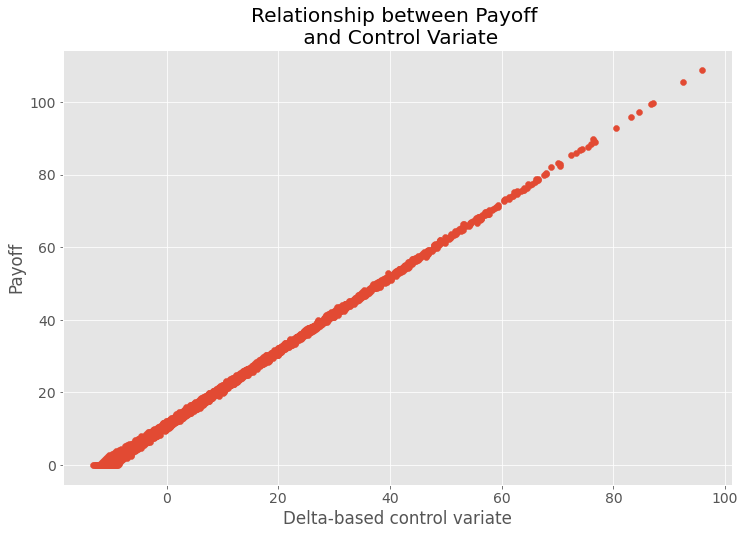

In [8]:
plt.scatter(cv[-1],Y)
plt.title('Relationship between Payoff \n and Control Variate')
plt.ylabel('Payoff')
plt.xlabel('Delta-based control variate')
plt.show()

##### Least-Squares Regression 

Find "True" relationship between control variate hedges and payoff.

In [9]:
X = np.vstack([np.ones(M), cv[-1]]).T
beta = np.linalg.lstsq(X, Y, rcond=1)[0]

print('Beta 0 (fair value T=0): ', round(beta[0],3))
print('Beta 1 (delta)         : ', round(beta[1],3))

Beta 0 (fair value T=0):  10.984
Beta 1 (delta)         :  1.023


##### Gamma Based Control Variate

The control variate is a random variable whose expected value we know, which is correlated with the varaible we are trying to estimate.

For example a gamma-based control variate ($cv_2$):

$\large cv_2 = \sum^{N-1}_{i=0} \frac{\delta^2 C_{t_i}}{\delta S^2}((\Delta S_{t_{i+1}})^2 - {\mathbb E}[(\Delta S_{t_i})^2])\exp{r(T-t_{i+1})}$

Where ${\mathbb E}[(\Delta S_{t_i})^2] = S_{t_i}^2 (\exp([2r+\sigma^2]\Delta t_i)-2\exp(r\Delta t_i)+1)$

In [146]:
# Initialise parameters
S0 = 100       # initial stock price
K = 100        # strike price
T = 1.0        # time to maturity in years
r = 0.05       # annual risk-free rate
vol = 0.20     # volatility (%)
div = 0        # continuous dividend yield

# steps
N = 252    # number of time intervals
M = 10000  # number of simulations

# Heston parameters 
kappa = 5.0
vt0 = vol**2    # variance
theta = 0.2**2
sigma = 0.02

In [10]:

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms

nudt = (r - div - 0.5*vt0)*dt
volsdt = np.sqrt(vt0*dt)
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# Generate Wiener variables

W = np.random.normal(0, 1, size=(N,M,2))

# initialise prices and variances
vt = np.full(shape=(M), fill_value=vt0)
St = np.full(shape=(M), fill_value=S0)

vtn = np.full(shape=(M), fill_value=0.0)
Stn = np.full(shape=(M), fill_value=0.0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

for j in range(1,N+1):
    # Compute hedge sensitivities
    call = fixed_strike_lookback_call(r, St, K, T-(j-1)*dt, St_max, np.sqrt(vt), div)
    delta = call.delta_fd()
    gamma = call.gamma_fd()
    vega = call.vega_fd()

    # Simulate variance processes
    vtn = vt + kappadt*(theta - vt) + sigmasdt*np.sqrt(vt)*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt)*dt
    Stn = St*np.exp( nudt + np.sqrt(vt*dt)*W[j-1,:,1] )
    
    # accumulate control variates
    cv1 += delta*(Stn - St*erddt)
    cv2 += gamma*((Stn - St)**2 - (egam1*np.exp(vt*dt) + egam2)*St**2)
    cv3 += vega*((vtn - vt) - (vt*eveg1+eveg2-vt))
    
    mask = np.where(Stn > St_max)
    St_max[mask] = Stn[mask]
    
    vt = vtn
    St = Stn
    
# Compute Expectation and SE
Y = np.maximum(0, St_max - K)

C0 = np.exp(-r*T)*np.sum(Y)/M
C0

18.369264260286077

In [11]:
X = np.vstack([np.ones(M), cv1, cv2, cv3]).T

beta = np.linalg.lstsq(X, Y, rcond=None)[0]
print('Beta 0        : ',round(beta[0],3))
print('Beta 1 (delta): ',round(beta[1],3))
print('Beta 2 (gamma): ',round(beta[2],3))
print('Beta 3 (vega) : ',round(beta[3],3))

Beta 0        :  19.28
Beta 1 (delta):  0.553
Beta 2 (gamma):  0.068
Beta 3 (vega) :  0.542


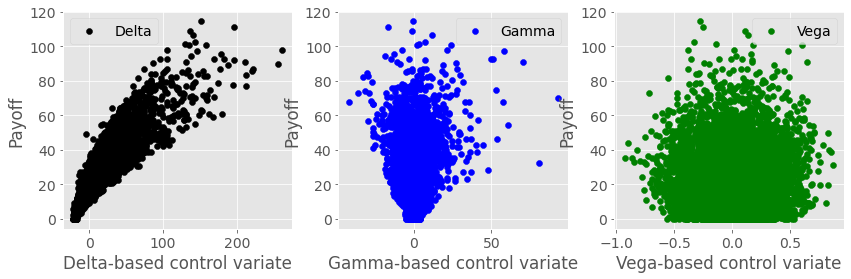

In [12]:
# Visualization of the control vaiate

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
naming = ['Delta','Gamma','Vega']
ax[0].scatter(cv1,Y,label=naming[0],color='k')
ax[1].scatter(cv2,Y,label=naming[1],color='b')
ax[2].scatter(cv3,Y,label=naming[2],color='g')
for i,a in enumerate(ax):
    a.set_ylabel('Payoff')
    a.set_xlabel(naming[i]+'-based control variate')
    a.legend()
plt.show()

In [13]:

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# linear constants pre-determined for control variate weighting
beta1 = -beta[1]#-0.88
beta2 = -beta[2]#-0.43
beta3 = -beta[3]#-0.0003

# Generate Wiener variables
W = np.random.normal(0.0, 1.0, size=(N,M,2))

# arrays for storing prices and variances
St = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

for j in range(1,N+1):
    
    # Compute hedge sensitivities
    call = fixed_strike_lookback_call(r, St[j-1], K, T-(j-1)*dt, St_max, np.sqrt(vt[j-1]), div)
    delta = call.delta_fd()
    gamma = call.gamma_fd()
    vega = call.vega_fd()

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    
    # accumulate control variates
    cv1 += delta*(St[j] - St[j-1]*erddt)
    cv2 += gamma*((St[j] - St[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St[j-1]**2)
    cv3 += vega*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1]))
    
    mask = np.where(St[j] > St_max)
    St_max[mask] = St[j][mask]
    
# Compute Expectation and SE
CT = np.maximum(0, St_max - K) + beta1*cv1 + beta2*cv2 + beta3*cv3
C0_cv = np.exp(-r*T)*np.sum(CT)/M

SE_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_cv)**2) / (M-1) ) /np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_cv,2),np.round(SE_cv,2)))


Call value is $18.3 with SE +/- 0.07


##### Antithetic and control Variate

In [21]:

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# linear constants pre-determined for control variate weighting
beta1 = -beta[1]#-0.88
beta2 = -beta[2]#-0.43
beta3 = -beta[3]#-0.0003

# Generate Wiener variables

W = np.random.normal(0, 1, size=(N,M,2))

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1): 
    # Compute hedge sensitivities
    call1 = fixed_strike_lookback_call(r, St1[j-1], K, T-(j-1)*dt, St1_max, np.sqrt(vt[j-1]), div)
    call2 = fixed_strike_lookback_call(r, St2[j-1], K, T-(j-1)*dt, St2_max, np.sqrt(vt[j-1]), div)
    delta1 = call1.delta_fd()
    delta2 = call2.delta_fd()
    gamma1 = call1.gamma_fd()
    gamma2 = call2.gamma_fd()
    vega1 = call1.vega_fd()
    vega2 = call2.vega_fd()

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    St2[j] = St2[j-1]*np.exp( nudt - np.sqrt(vt[j]*dt)*W[j-1,:,1] )
    
    # accumulate control variates
    cv1 += delta1*(St1[j] - St1[j-1]*erddt) + delta2*(St2[j] - St2[j-1]*erddt)
    cv2 += gamma1*((St1[j] - St1[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St1[j-1]**2) \
         + gamma2*((St2[j] - St2[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St2[j-1]**2)
    cv3 += vega1*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1])) \
         + vega2*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1]))
    
    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]
    
# Compute Expectation and SE
CT = 0.5*(np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) \
      + beta1*cv1 + beta2*cv2 + beta3*cv3)

C0_acv = np.exp(-r*T)*np.sum(CT)/M

SE_acv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_acv)**2) / (M-1) ) /np.sqrt(M)


print("Call value is ${0} with SE +/- {1}".format(np.round(C0_acv,2),np.round(SE_acv,2)))

Call value is $18.3 with SE +/- 0.04


##### Comparing Variance Reduction Methods

In [28]:
C0_variates = [C0_slow, C0_fast, C0_av, C0_cv, C0_acv]
se_variates = [SE_slow, SE_fast, SE_av, SE_cv, SE_acv]
se_red = [round(SE_fast/se,2) for se in se_variates]
data = {'Lookback Call Option Value': np.round(C0_variates,3), 
        'Standard Error': np.round(se_variates,3), 
        'SE Reduction Multiple': se_red}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =['Slow ', 'Fast ', 'with antithetic variate', 
'with control variates', 'with antithetic and control variates'])  
df

,Lookback Call Option Value,Standard Error,SE Reduction Multiple
Slow,18.113,0.152,1.00
Fast,18.055,0.151,1.00
with antithetic variate,18.407,0.062,2.43
with control variates,18.299,0.074,2.04
with antithetic and control variates,18.301,0.040,3.81
